**ITS_LIVE Python Library Demo: Time Series of Ice Flow Speed Along a Profile (like a centerline)**

ITS_LIVE (Intermission Time Series of Land Ice Velocity and Elevation, http:itslive.jpl.nasa.gov) maintains an archive of ice flow speeds for glaciers and ice sheets.
These speeds are determined from pairs of satellite images by tracking how far features move from the first image in a pair to the second image in a pair.

As a result, the time series of ice motion at a single location on a glacier consist of measurements of the average speed of the ice at that point over the time interval between the two images used.

Because ITS_LIVE determines the offsets between the two images on a regular 120 m grid, resulting in a velocity map from each image pair, and because these velocity maps are then stacked in time in "Data Cubes", it is possble to efficiently extract time series for a vector of points, such as evenly spaced points along a center flow line.

In this notebook we extract such a dataset, and then plot it in a way to visualize the time evolution of ice flow along that centerline.

The profile used below is defined by 4 points:
![alt text](Screenshot_Malaspina_profile_points.png "Malaspina Centerline Profile Points")

You can generate the above figure, including locations of these points and the speed histories at the points, here: https://mappin.itsliveiceflow.science/chart?lat=59.75571&lng=-140.83322&c=b&lat=59.86874&lng=-140.75332&c=g&lat=59.97592&lng=-140.62665&c=r&lat=60.08311&lng=-140.46295&c=y


**the code below generates an evenly sampled set of points along that profile and plots the detailed ice flow history along that profile from ITS_LIVE data**

In [1]:
%matplotlib inline

import itslive
from pyproj import Transformer
import utm

from tqdm import tqdm

# we need several matplotlib components to make this plot
from matplotlib import pyplot as plt
# from matplotlib import collections  as mc
# from matplotlib import dates as mdates
from matplotlib import colors as mpl_colors
from matplotlib import cm  as mpl_cm
from matplotlib import ticker as mpl_ticker

import numpy as np

def dt64_to_decimal_year(dt64_in):
    year_int = dt64_in.astype('datetime64[Y]').astype(int) + 1970
    days_in_year = ( np.datetime64(f"{year_int+1}-01-01") - np.datetime64(f"{year_int}-01-01") ).astype(float)
    decimal_year = float(year_int) + ( ( dt64_in - np.datetime64(f"{year_int}-01-01T00:00") ).astype('timedelta64[D]').astype(float) / days_in_year )
    return decimal_year

def vec_dt64_to_decimal_year(vec_dt64_in):
    out_dec_year_list = []
    for dt64_in in vec_dt64_in:
        out_dec_year_list.append(dt64_to_decimal_year(dt64_in))
    return np.array(out_dec_year_list)


In [2]:
#
# specify centerline lon,lat pairs
#
# find appropriate projection, convert points to that projection, generate evenly spaced sample points, convert back to lon,lat for itslive call
#

del_interval = 1000.0 # sample every del_interval meters along profile

# profile:
centerline_lon_lat_list = [
                            (-140.83322058712292, 59.7557082654018),
                            (-140.7533199251939, 59.86873847008192),
                            (-140.62664814408686, 59.975922284864794),
                            (-140.46294922696393, 60.083106099647665),
                          ]
# find best projection for evenly spacing sample points (lat,lon won't work)
mean_lon = np.mean([x for x,y in centerline_lon_lat_list])
mean_lat = np.mean([y for x,y in centerline_lon_lat_list])

x,y,zone_num,zone_letter = utm.from_latlon(mean_lat,mean_lon)
if mean_lat < -65.0: # Antarctica - SCAR PS
    epsg = 3031
elif mean_lat > 65: # northern NSIDC PS
    epsg = 3413
else: # figure out local UTM
    x,y,zone_num,zone_letter = utm.from_latlon(mean_lat,mean_lon)
    if mean_lat >= 0.0:
        epsg = int(f'326{zone_num:02d}')
    else:
        epsg = int(f'327{zone_num:02d}')

print(f'using EPSG:{epsg}')

# set up tranformations to local xy projection to evenly space; and from that xy back to lat,lon
ll_to_xy_transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{epsg}")
xy_to_ll_transformer = Transformer.from_crs(f"EPSG:{epsg}","EPSG:4326")

pts_xy = []
for lon,lat in centerline_lon_lat_list:
    x,y = ll_to_xy_transformer.transform(lat,lon)
    print(f'{x} {y} {lon} {lat}')
    pts_xy.append((x,y))


deldiffs=np.diff(pts_xy,axis=0)   # delta x and delta y between adjacent points
deldist=[np.sqrt(x**2 + y**2) for x,y in deldiffs]
cl_dist=np.zeros(len(pts_xy))
cl_dist[1:]=np.cumsum(deldist)  # set to be zero distance at start
mfdel=np.modf(cl_dist/del_interval)
ddint=np.diff(mfdel[1])    # integer part of ratio above - then find steps in that

num_samp_pnts=np.max(mfdel[1]).astype(int) + 1    # maximum number of integer del_intervals that fit in cl_dist max
samp_pnts_x=np.zeros(num_samp_pnts)
samp_pnts_y=np.zeros(num_samp_pnts)
samp_pnts_x[0]=pts_xy[0][0]
samp_pnts_y[0]=pts_xy[0][1]
samp_pnts_dist=np.arange(0.0,del_interval * num_samp_pnts,del_interval)
samp_pnts_dist

for i in np.where(ddint>0)[0]:
    numpntstoadd=ddint[i]
    pntindex=mfdel[1].astype(int)[i]    # mfdel[1] is integer part of mod - so the point index for regularly spaced points
    delx=deldiffs[i][0]
    dely=deldiffs[i][1]
    startx=pts_xy[i][0]
    starty=pts_xy[i][1]
    for j in range(1,int(numpntstoadd)+1):
        frac= (deldist[i] - (del_interval*(float(numpntstoadd - j) + mfdel[0][i+1])))/deldist[i]    # fraction of total input pnt distance for the jth integer point
        samp_pnts_x[pntindex+j]=startx + (frac*delx)
        samp_pnts_y[pntindex+j]=starty + (frac*dely)

samp_pnts_lat, samp_pnts_lon = xy_to_ll_transformer.transform(samp_pnts_x,samp_pnts_y)

dist_min, dist_max = samp_pnts_dist[0], samp_pnts_dist[-1]

disthalfbin = (samp_pnts_dist[1] - samp_pnts_dist[0])/2.0 # for plotting patches

num_sample_points = len(samp_pnts_dist)

using EPSG:32607
509371.05989906756 6624217.266427279 -140.83322058712292 59.7557082654018
513813.6901897752 6636818.7577694515 -140.7533199251939 59.86873847008192
520839.75765809655 6648788.502608469 -140.62664814408686 59.975922284864794
529880.0650270837 6660787.964816882 -140.46294922696393 60.083106099647665


In [3]:
# get itslive data at each of the evenly spaced points

print(f'fetching time series for {len(samp_pnts_dist)} points', flush=True)
tseries = itslive.data_cube.get_time_series(zip(samp_pnts_lon,samp_pnts_lat),variables=['v','acquisition_date_img1','acquisition_date_img2','date_dt'])
print(f'done fetching time series', flush=True)

fetching time series for 43 points
done fetching time series


In [4]:
# set up limits for plot
plot_speed_max = 2800 # m/yr
# plot_speed_max = 6000 # m/yr

use_logscale = False

# year_min = 1985.0
year_min = 2013.0
year_max = 2023.1

speed_min = 0
# year_min = profiles[0][1]['start_dec_year']
# year_max = profiles[-1][1]['stop_dec_year']

# colormap = plt.get_cmap('viridis') 
colormap = plt.get_cmap('jet') 
# cNorm  = colors.Normalize(vmin=0, vmax=plot_speed_max)
if use_logscale == True:
    cNorm  = mpl_colors.LogNorm(vmin=10.0, vmax=plot_speed_max)
else:
    cNorm  = mpl_colors.Normalize(vmin=0.0, vmax=plot_speed_max)

scalarMap = mpl_cm.ScalarMappable(norm=cNorm, cmap=colormap)
print(scalarMap.get_clim())

(0.0, 2800.0)


In [5]:
plotted_points = []

#
# for each evenly spaced point on the profile, calculate polygons for every velocity measurement at that point that
# extend from half way to the prior and next points in x, and from the date of the first image to the date of the second image used for speed in the y (time) axis
# note that the points are sorted by reverse of the time separation between the images (date_dt in days), so that longer date_dts are plotted first, underneath shorter date_dts
# this keeps the long intervals from covering the shorter ones - showing all the short time variation in the record
#

for i,dist in tqdm( enumerate(samp_pnts_dist), total = len(samp_pnts_dist), desc = 'calculating points'):
    if i==0:
        x_start = dist
        x_stop = dist + disthalfbin
    elif i==num_sample_points - 1:
        x_start = dist - disthalfbin
        x_stop = dist
    else:
        x_start = dist - disthalfbin
        x_stop = dist + disthalfbin

    ts = tseries[i]['time_series']

    v_all = ts.v.values
    v = v_all[~np.isnan(v_all)]

    start_dt64 = ts.acquisition_date_img1.values[~np.isnan(v_all)]
    start_dec_year = vec_dt64_to_decimal_year(start_dt64)

    stop_dt64 = ts.acquisition_date_img2.values[~np.isnan(v_all)]
    stop_dec_year = vec_dt64_to_decimal_year(stop_dt64)

    date_dt = ts.date_dt.values[~np.isnan(v_all)].astype('timedelta64[D]').astype(int)


    column_pts = list( zip(date_dt,v,start_dec_year,stop_dec_year) )
    column_pts.sort(reverse=True)

    for date_dt,v,pt_start_dec_year,pt_stop_dec_year in column_pts:
            cind=v
            if cind>plot_speed_max:
                cind=plot_speed_max
            colorVal = scalarMap.to_rgba(cind)
        
            xvec=[x_start,x_stop,x_stop,x_start,x_start]
            yvec=[pt_start_dec_year,pt_start_dec_year,pt_stop_dec_year,pt_stop_dec_year,pt_start_dec_year]
            plotted_points.append((xvec,yvec,colorVal))
            
print(f'finished calculating {len(plotted_points)} polygons for plot')

calculating points: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:39<00:00,  1.08it/s]

finished calculating 166899 polygons for plot


plotting points: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166899/166899 [01:53<00:00, 1465.43it/s]

rendering figure...


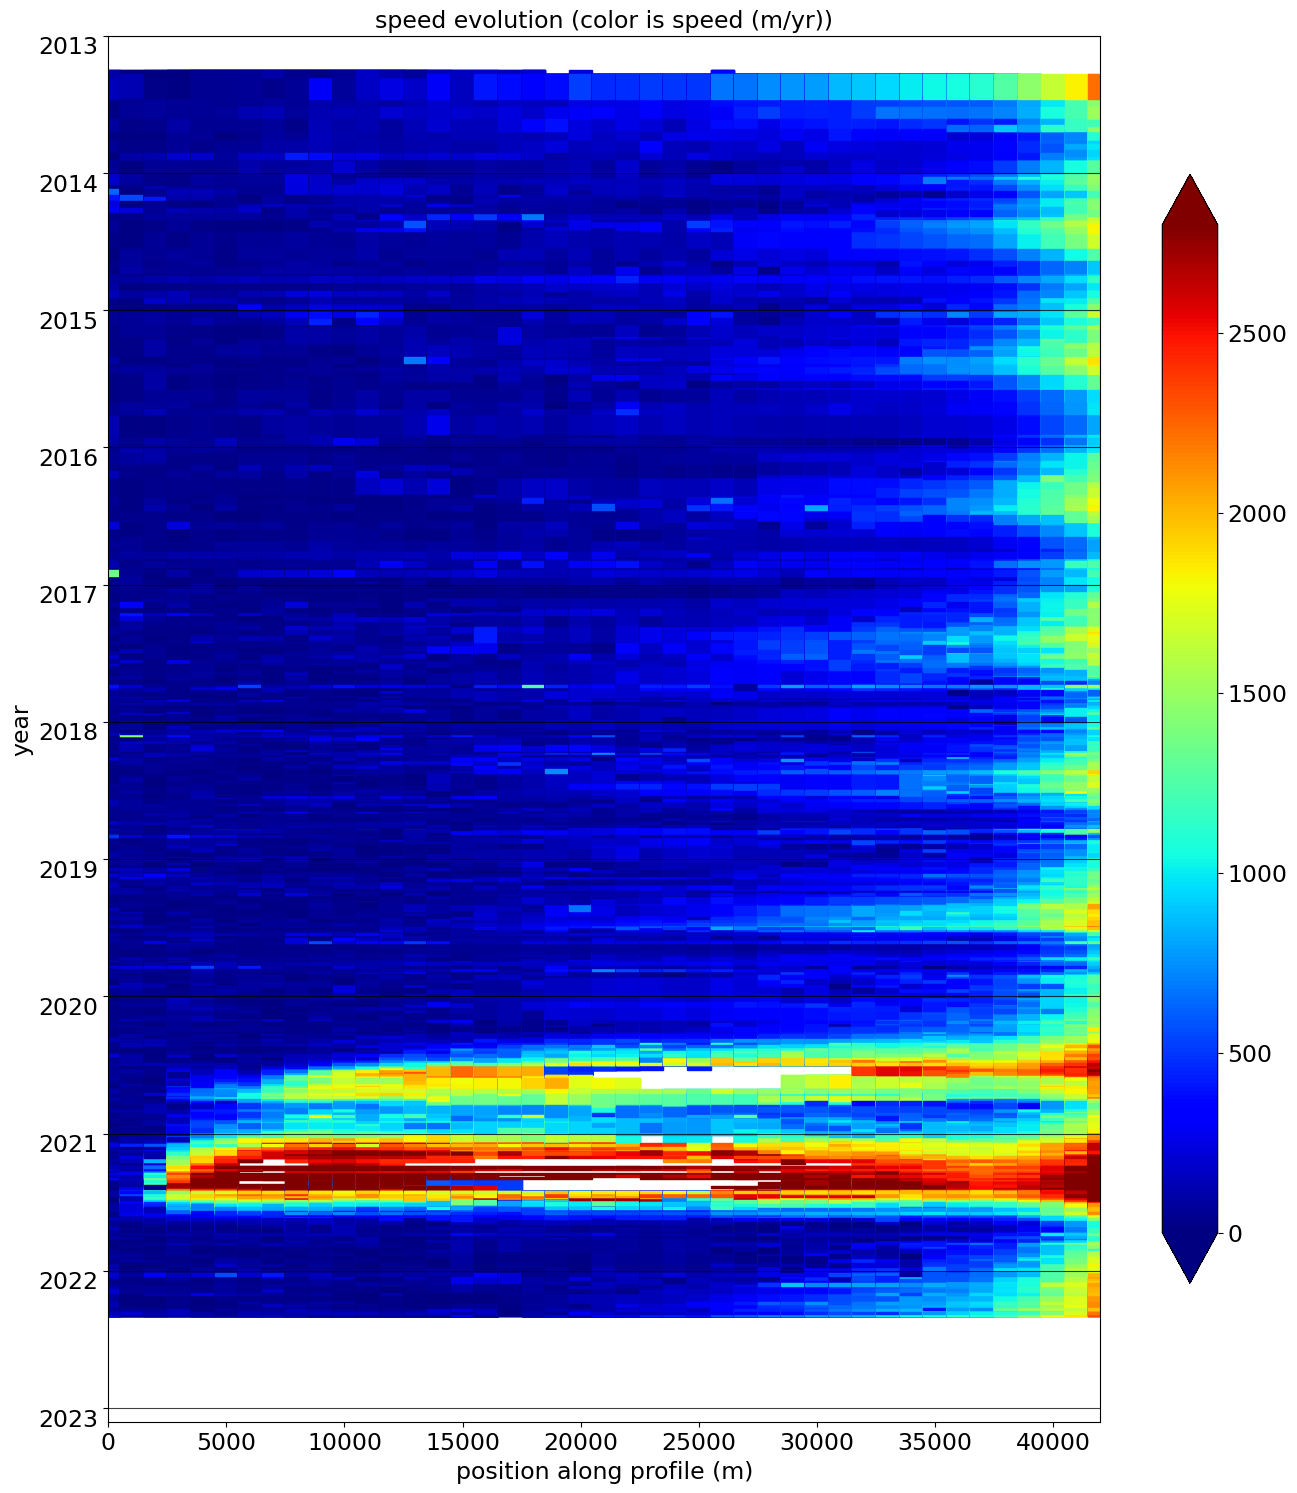

In [6]:
fig2,ax2 = plt.subplots(1,figsize=(16.0,18.0), dpi=100)
plt.ion()


if use_logscale == True:
    ax2.set_title('speed evolution (color is speed (m/yr, log scale))')
else:
    ax2.set_title('speed evolution (color is speed (m/yr))')

ax2.set_xlabel('position along profile (m)')
ax2.set_ylabel('year')
# label every year, with top of label at start of year
ax2.set_yticks(np.arange(year_min,year_max,1.0))
plt.setp( ax2.yaxis.get_majorticklabels(), va="top" )

ax2.set_autoscalex_on(False)
ax2.set_xlim([dist_min, dist_max])
ax2.set_autoscaley_on(False)
ax2.set_ylim([year_min, year_max])
ax2.invert_yaxis()
# ax2.grid(axis='y',which='major',color='k',linestyle='-', alpha=0.75)
ax2.grid(axis='y',which='both',color='k',linestyle='-', alpha=0.75)
color_min=speed_min
color_max=plot_speed_max

for point in tqdm(plotted_points, desc = 'plotting points'):
    ax2.fill(point[0],point[1],color=point[2])

print('rendering figure...', flush=True)

scalarMap._A=[]   # need to set this array even though not used in order to get colormap function to work
cb2=plt.colorbar(scalarMap, ax=ax2, shrink = 0.8, extend = 'both')

if use_logscale == True:
    cb2_yticks = cb2.ax.get_yticks()
    labels = []
    for val in cb2_yticks:
        if val >= 10 and val <= 1000:
            labels.append(f"{int(val):d}")
        else:
            labels.append('')
    cb2.ax.set_yticklabels(labels)


y_formatter = mpl_ticker.ScalarFormatter(useOffset=False)
ax2.yaxis.set_major_formatter(y_formatter)
for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels() + cb2.ax.get_yticklabels()):
    item.set_fontsize(17)

The profile is chosen with the first point (blue X in top figure) at the lower end of the ice (0 m at the left edge). In this plot the ice is flowing from the right to the left.

One can see the seasonal cycle in speed (slowest in Fall) in the upper glacier, and the surge of the Malaspina 2020 and 2021, when the entire glacier along this centerline reached speeds > 2500 m/yr, or 6.8 m/day.